# 项目介绍

文本二分类示例

 - 模型架构：`LSTM`
 - 深度学习框架： `tensorflow2`
 - 数据集： 中文评论情感分析语料 `chnsenticorp`

In [1]:
import os
import re
import datetime
import logging


# Disable Tensorflow log information 
# https://stackoverflow.com/questions/35911252/disable-tensorflow-debugging-information
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.captureWarnings(True)


import tensorflow as tf
from tensorflow import keras
from tensorflow_text import FastBertTokenizer
from paddlenlp.datasets import load_dataset
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

from zh_nlp_demo.utils.tokenization import FullTokenizer

# 1. 加载数据

In [2]:
[train_examples, dev_examples, test_examples] = load_dataset('chnsenticorp', splits=('train', 'dev', 'test'))

print('训练集样本数量： ', len(train_examples))
print('验证集样本数量： ', len(dev_examples))
print('测试集样本数量： ', len(test_examples))

print('训练集样本示例：')
print(train_examples[0])

训练集样本数量：  9600
验证集样本数量：  1200
测试集样本数量：  1200
训练集样本示例：
{'text': '选择珠江花园的原因就是方便，有电动扶梯直接到达海边，周围餐馆、食廊、商场、超市、摊位一应俱全。酒店装修一般，但还算整洁。 泳池在大堂的屋顶，因此很小，不过女儿倒是喜欢。 包的早餐是西式的，还算丰富。 服务吗，一般', 'label': 1, 'qid': ''}


# Tokenizer


中文的 tokenizer 与英语不同，英语一般根据空格拆分就可以得的结果效果就不错，

中文的 tokenize 分为两类，一类是基于字的，一类是基于词的。两种方法都各有优缺点：基于字的好处是词典表较小，不容易出现 OOV，但缺点是容易丢失词的的信息；基于词的好处是保留了词的信息，但缺点也很明显，分词质量的好坏对结果影响比较大，另外基于词的 tokenize 容易出现 OOV 的情况。

我偏向于使用基于字的 tokenize ，现在的深度学习网络参数都很多，网络也比较深，词的信息模型可以从数据里面学到。


几种不同的 Tokenizer 比较

`tensorflow.keras.preprocessing.text.Tokenizer`

调研发现，tensorflow 提供的标准 Tokenizer 对中文支持的都有限，需要对句子先进行分词，或者按字拆开，若句子中有英文、数字等也会拆为单个字符。


`text.fast_bert_tokenizer`

中文处理比较好
返回的数据类型为 tf.RaggedTensor
返回的数据中包含 CLS 标签


`bert 原版代码中的 tokenizer`

https://github.com/google-research/bert/blob/master/tokenization.py

中文处理比较好
可以做到仅依赖python标准库

鉴于上述的 Tokenizer 我自己对 `bert 原版代码中的 tokenizer` 进行修改，主要是移除了 支持 Python2 的代码，以及跟 tensorflow 相关的代码。这样，就可以用在不同的框架中。

In [3]:
tokenizer = FullTokenizer('../../pre_train/tensorflow/Chinese_BERT_wwm/RoBERTa-wwm-ext/vocab.txt')

def examples_to_ids(tokenizer, examples, maxlen=200, num_classes=2):
    tokens = [tokenizer.tokenize(example['text']) for example in examples]
    input_ids = [tokenizer.convert_tokens_to_ids(tokens) for tokens in tokens]
    input_x = keras.preprocessing.sequence.pad_sequences(input_ids, maxlen=maxlen)

    input_y = keras.utils.to_categorical([example['label'] for example in examples], num_classes=num_classes)

    return input_x, input_y


train_x, train_y = examples_to_ids(tokenizer, train_examples)
dev_x, dev_y = examples_to_ids(tokenizer, train_examples)
test_x, test_y = examples_to_ids(tokenizer, train_examples)

print(train_x[0])
print(train_y[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 6848
 2885 4403 3736 5709 1736 4638 1333 1728 2218 3221 3175  912 8024 3300
 4510 1220 2820 3461 4684 2970 1168 6809 3862 6804 8024 1453 1741 7623
 7667  510 7608 2443  510 1555 1767  510 6631 2356  510 3033  855  671
 2418  936 1059  511 6983 2421 6163  934  671 5663 8024  852 6820 5050
 3146 3815  511 3807 3737 1762 1920 1828 4638 2238 7553 8024 1728 3634
 2523 2207 8024  679 6814 1957 1036  948 3221 1599 3614  511 1259 4638
 3193 7623 3221 6205 2466 4638 8024 6820 5050  705 2168  511 3302 1218
 1408 

# 构建模型

模型架构为 两层双向LSTM模型和一个全连接层

In [4]:
vocab_size = len(tokenizer.vocab)
embedding_dim = 128

model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True),
    keras.layers.Bidirectional(keras.layers.LSTM(embedding_dim, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.LSTM(embedding_dim, dropout=0.5, recurrent_dropout=0.5)),
    keras.layers.Dense(embedding_dim, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         2704384   
                                                                 
 bidirectional (Bidirectiona  (None, None, 256)        263168    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 2

In [5]:
# 启动 tensorboard

# Load the TensorBoard notebook extension
%load_ext tensorboard

# %tensorboard --logdir logs

In [6]:
model.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
# model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])

num_epochs = 20

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history = model.fit(train_x, train_y, epochs=num_epochs, validation_data=(dev_x, dev_y), verbose=2, callbacks=[tensorboard_callback])

Epoch 1/20
300/300 - 206s - loss: 0.4622 - accuracy: 0.7811 - val_loss: 0.2983 - val_accuracy: 0.8829 - 206s/epoch - 685ms/step
Epoch 2/20
300/300 - 197s - loss: 0.3337 - accuracy: 0.8687 - val_loss: 0.2436 - val_accuracy: 0.9071 - 197s/epoch - 655ms/step
Epoch 3/20
300/300 - 196s - loss: 0.2800 - accuracy: 0.8961 - val_loss: 0.2040 - val_accuracy: 0.9301 - 196s/epoch - 654ms/step
Epoch 4/20
300/300 - 196s - loss: 0.2324 - accuracy: 0.9149 - val_loss: 0.1574 - val_accuracy: 0.9532 - 196s/epoch - 655ms/step
Epoch 5/20
300/300 - 197s - loss: 0.1964 - accuracy: 0.9304 - val_loss: 0.1344 - val_accuracy: 0.9536 - 197s/epoch - 655ms/step
Epoch 6/20
300/300 - 198s - loss: 0.1761 - accuracy: 0.9392 - val_loss: 0.1021 - val_accuracy: 0.9679 - 198s/epoch - 661ms/step
Epoch 7/20
300/300 - 196s - loss: 0.1481 - accuracy: 0.9486 - val_loss: 0.1089 - val_accuracy: 0.9571 - 196s/epoch - 653ms/step
Epoch 8/20
300/300 - 196s - loss: 0.1206 - accuracy: 0.9606 - val_loss: 0.0594 - val_accuracy: 0.9830 - 

(0.0, 0.48456650469452145)

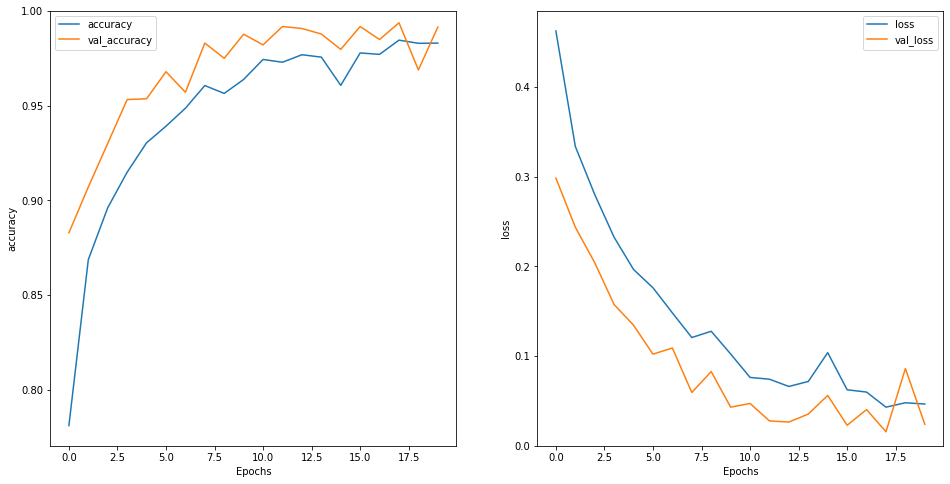

In [7]:
# 直接看 tensorboard 效果更好

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
  

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [8]:
pred_result = model.predict(test_x)
pred_y = pred_result.argmax(axis=1)
test_y = test_y.argmax(axis=1)
print(classification_report(test_y, pred_y))

300/300 [==============================] - 27s 89ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4801
           1       0.99      0.99      0.99      4799

    accuracy                           0.99      9600
   macro avg       0.99      0.99      0.99      9600
weighted avg       0.99      0.99      0.99      9600

